## Burstiness
- Burstiness refers to sudden spikes in activity or usage over a short period. This can help identify periods of high resource demand.
- High burstiness may indicate inefficiencies or unusual workload patterns.

Probably the easiest way to do it is to look at <b> max-to-mean ratio:
- Use it as a measure of variability and peak usage relative to average usage.
- A high max-to-mean ratio might indicate significant variability and the presence of peaks well above the average.
- A low max-to-mean ratio might indicate more consistent and stable usage.
    
People also use this as a threshold <b> mean + 2 * std </b>, when they explore burstiness but I'm not sure if that's the best way for us.
    
Exploring the Kleinberg’s burst detection algorithm below.

## How can this analysis be useful?

- We can investigate how certain metrics evolve over time and identify trends in resource utilization.
- We can detect bursts in resource usage related to specific jobs or applications.
- We can further investigate peak times.

Questions we can try to answer using this analysis:
- Are there specific times under which certain metrics exhibit bursts?
- Which jobs or applications cause the most significant bursts in resource utilization?
- How do bursts in different metrics correlate with each other?
- Are there particular users who consistently cause bursts in resource utilization?


In [177]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import burst_detection as bd
import sympy.functions.combinatorial.factorials as c

In [178]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [179]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [180]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100].copy()
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1].copy()
            ldms_dataframe.loc[:, metric] = ldms_dataframe[metric] * 100
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

## Kleinberg’s burst detection algorithm

Taken from https://github.com/nmarinsek/burst_detection/tree/master

Burst detection identifies time periods in which a target event is uncharacteristically frequent, or "bursty." 

d: total number of events at each time point <br>
r: the number of target events

There are two conditions:
- The event happens at its normal rate.
- The event happens more often than usual.

The algorithim basically calculates the normal rate (baseline) and the increased rate (burst) of the event happening, and determines when the event frequency shifts from normal (baseline) to increased (burst).

More information about the algorithm: https://nikkimarinsek.com/blog/kleinberg-burst-detection-algorithm

In [185]:
# define the transition cost tau: cost of switching states
# there's a cost to move up states, no cost to move down
# based on definition on pg. 8
# inputs
#   i1: current state
#   i2: next state
#   gam: gamma, penalty for moving up a state
#   n: number of timepoints
def tau(i1, i2, gamma, n):
    if i1 >= i2:
        return 0
    else:
        return (i2 - i1) * gamma * np.log(n)

# define the fit cost: goodness of fit to the expected outputs of each state
# based on equation on bottom of pg. 14
#    d: number of events in each time period (1xn)
#    r: number of target events in each time period (1xn)
#    p: expected proportions of each state (1xk)
def fit(d, r, p):
    if d >= r and p > 0 and p < 1:
        return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
    else:
        return np.inf

# define the burst detection function for a two-state automaton
# inputs:
#   r: number of target events in each time period (1xn)
#   d: number of events in each time period (1xn)
#   n: number of timepoints
#   s: multiplicative distance between states
#   gamma: difficulty to move up a state
#   smooth_win: width of smoothing window (use odd numbers)
# output:
#   q: optimal state sequence (1xn)
def burst_detection(r, d, n, s, gamma, smooth_win):
    k = 2 # two states
    
    # smooth the data if the smoothing window is greater than 1
    if smooth_win > 1:
        temp_p = r / d # calculate the proportions over time and smooth
        temp_p = temp_p.rolling(window=smooth_win, center=True).mean()
        # update r to reflect the smoothed proportions
        r = temp_p * d
        real_n = sum(~np.isnan(r))  # update the number of timepoints
    else:
        real_n = n
          
    # calculate the expected proportions for states 0 and 1
    p = {}
    p[0] = np.nansum(r) / float(np.nansum(d))   # overall proportion of events, baseline state
    p[1] = p[0] * s                             # proportion of events during active state
    if p[1] > 1:                                # p1 can't be bigger than 1
        p[1] = 0.99999

    # initialize matrices to hold the costs and optimal state sequence
    cost = np.full([n, k], np.nan)
    q = np.full([n, 1], np.nan)

    # use the Viterbi algorithm to find the optimal state sequence
    for t in range(int((smooth_win - 1) / 2), (int((smooth_win - 1) / 2)) + real_n):
        # calculate the cost to transition to each state
        for j in range(k): 
            # for the first timepoint, calculate the fit cost only
            if t == int((smooth_win - 1) / 2):
                cost[t, j] = fit(d[t], r[t], p[j])
            # for all other timepoints, calculate the fit and transition cost
            else:
                cost[t, j] = tau(q[t - 1], j, gamma, real_n) + fit(d[t], r[t], p[j])

        # add the state with the minimum cost to the optimal state sequence
        q[t] = np.argmin(cost[t, :])

    return q, d, r, p

# define a function to enumerate the bursts
# input: 
#   q: optimal state sequence
# output:
#   bursts: dataframe with beginning and end of each burst
def enumerate_bursts(q, label):
    bursts = pd.DataFrame(columns=['label', 'begin', 'end', 'weight'])
    b = 0
    burst = False
    for t in range(1, len(q)):
        if (burst == False) & (q[t] > q[t - 1]):
            bursts.loc[b, 'begin'] = t
            burst = True
        if (burst == True) & (q[t] < q[t - 1]):
            bursts.loc[b, 'end'] = t
            burst = False
            b = b + 1

    # if the burst is still going, set end to last timepoint
    if burst == True:
        bursts.loc[b, 'end'] = t

    bursts.loc[:, 'label'] = label
    return bursts

# define a function that finds the weights associated with each burst
# find the difference in the cost functions for p0 and p1 in each burst 
# inputs:
#   bursts: dataframe containing the beginning and end of each burst
#   r: number of target events in each time period
#   d: number of events in each time period
#   p: expected proportion for each state
# output:
#   bursts: dataframe containing the weights of each burst, in order
def burst_weights(bursts, r, d, p):
    # loop through bursts
    for b in range(len(bursts)):
        cost_diff_sum = 0
        for t in range(int(bursts.loc[b, 'begin']), int(bursts.loc[b, 'end']) + 1):
            cost_diff_sum += (fit(d[t], r[t], p[0]) - fit(d[t], r[t], p[1]))
        bursts.loc[b, 'weight'] = cost_diff_sum
    return bursts.sort_values(by='weight', ascending=False)

## Plot the bursts

In [186]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

def plot_burst_timeline(bursts, timepoints, label):
    if isinstance(timepoints, int):
        timepoints = np.arange(timepoints)
        
    f, ax = plt.subplots(figsize=(12, 2))
    ax.set_xlim(0, len(timepoints))
    ax.set_ylim(0, 1)
    
    # Define a color map
    norm = mcolors.Normalize(vmin=bursts['weight'].min(), vmax=bursts['weight'].max())
    cmap = plt.get_cmap('cool')

    # Create boxes around bursting periods
    for index, burst in bursts.iterrows():
        # Define outline positions
        y = 0.25
        xstart = burst['begin']
        width = burst['end'] - burst['begin']

        # Draw rectangle with color based on weight
        ax.add_patch(Rectangle((xstart, y), width, 0.5,
                               facecolor=cmap(norm(burst['weight'])), edgecolor='none', linewidth=1))

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.3)
    cbar.set_label('Burst Weight')

    # Set x-axis labels
    ax.set_xticks(np.arange(0, len(timepoints), max(1, len(timepoints) // 10)))
    ax.set_xticklabels(timepoints[::max(1, len(timepoints) // 10)])
    
    # Set y-axis label
    plt.yticks([0.5], [label], size=14)
    
    # Remove unnecessary spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Add a timeline
    plt.axhline(0.5, linewidth=1, color='k', alpha=1, zorder=0.5)

    plt.show()

## A toy example

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


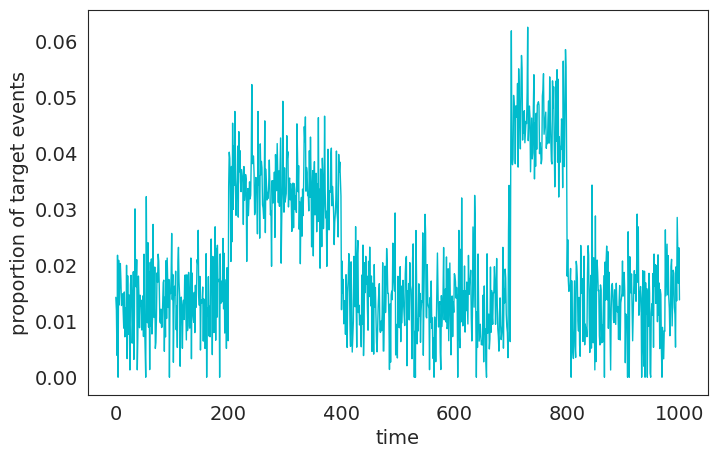

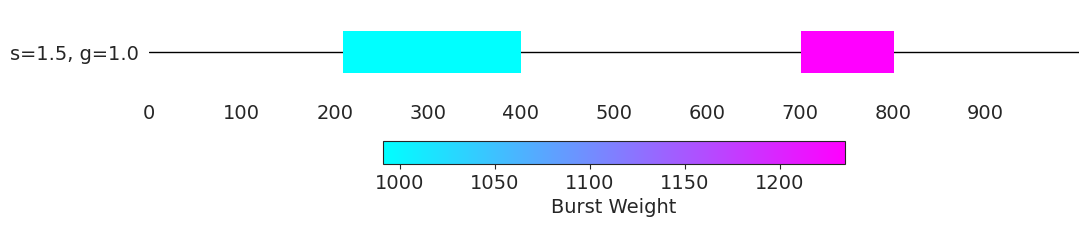

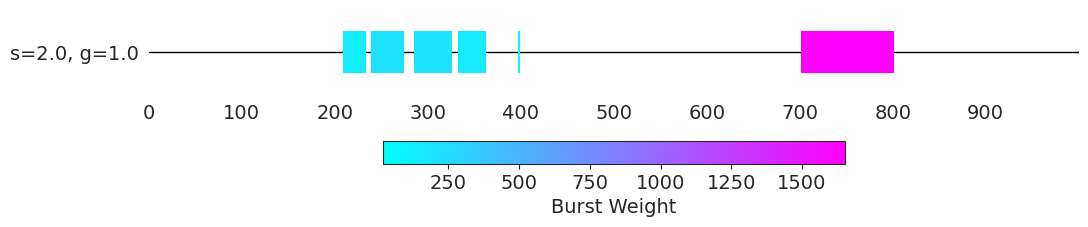

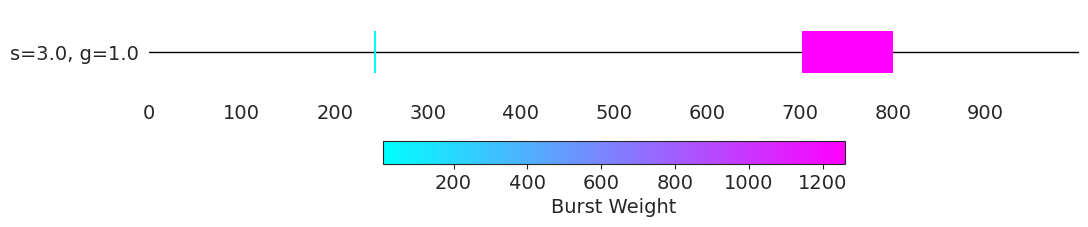

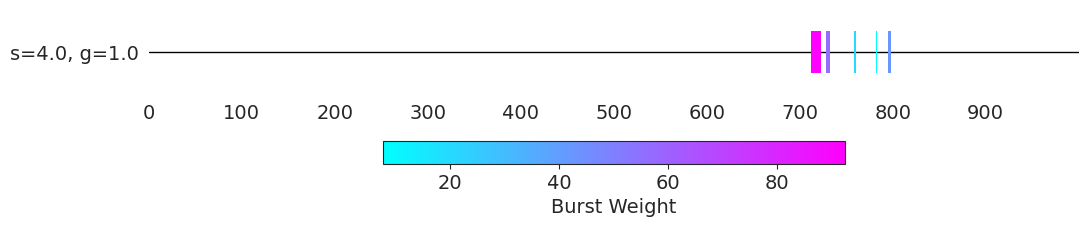

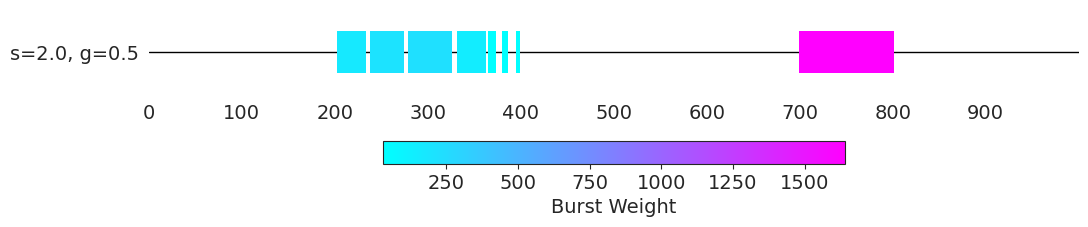

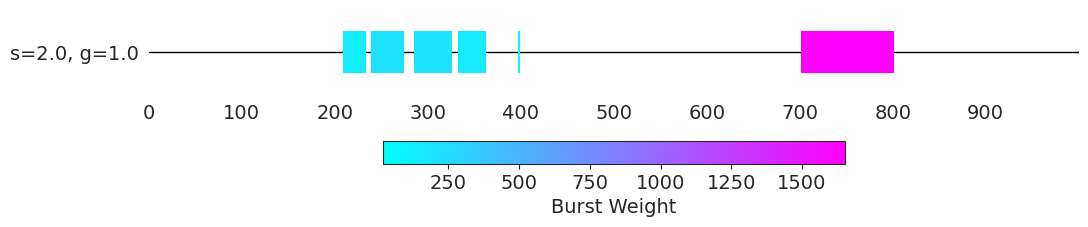

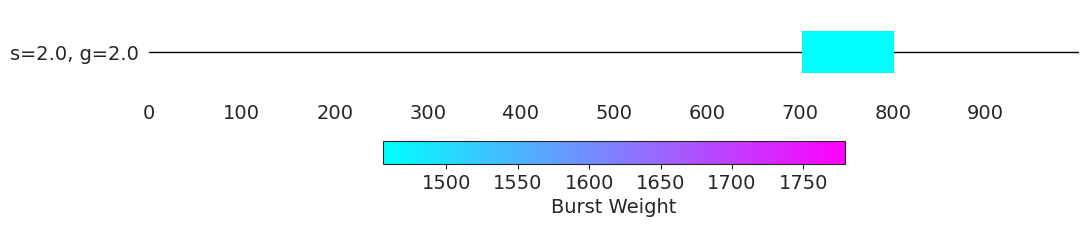

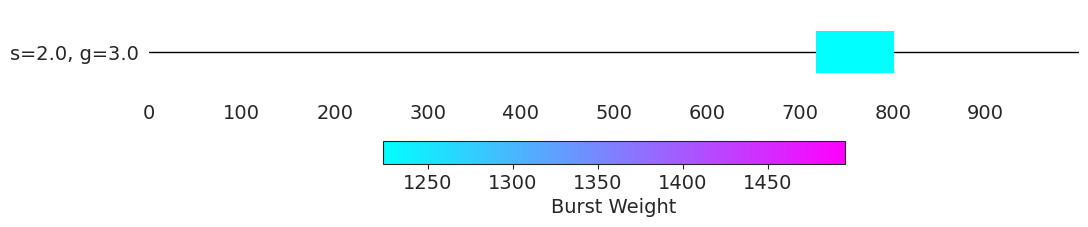

In [187]:
import pandas as pd
import numpy as np
import burst_detection as bd

import matplotlib.pyplot as plt  
import seaborn as sns
from matplotlib import rcParams
import sympy.functions.combinatorial.factorials as c
%pylab inline 

#set plot properties
sns.set_style("white")
rcParams['font.size'] = 14

#simulate the baseline data
timepoints = 1000
d = pd.Series(np.floor(np.ones(timepoints)*1500 + np.random.normal(scale=40, size=timepoints))) #total events
r = pd.Series(np.floor(np.ones(timepoints)*20 + np.random.normal(scale=10, size=timepoints)))   #target events
r[r<0] = 0 #set negative values to 0

#add some bursts
r[200:400] = r[200:400] + 30 #+ np.random.normal(scale=10, size=200)
r[700:800] = r[700:800] + 50 #+ np.random.normal(scale=10, size=100)

org_r = r

plt.subplots(figsize=(8, 5))
plt.plot(org_r/d, color='#00bbcc', linewidth=1)
plt.yticks(size=14);
plt.xticks(size=14);
plt.ylabel('proportion of target events', size=14)
plt.xlabel('time', size=14)
plt.savefig("raw_timeseries.jpg", bbox_inches="tight", dpi=600)

#find bursts

#define variables
n = len(r)    #number of timepoints
k = 2         #number of states

#col 0: s -- resolution of state jumps; higher s --> bigger jumps between states
#col 1: gamma -- difficulty of moving up a state; larger gamma --> harder to move up states
variables = [[1.5, 1.0],
             [2.0, 1.0],
             [3.0, 1.0],
             [4.0, 1.0],
             [2.0, 0.5],
             [2.0, 1.0],
             [2.0, 2.0],
             [2.0, 3.0]]

for v in variables:

    #find the optimal state sequence (using the Viterbi algorithm)
    [q, _, _, p] = burst_detection(r,d,n,v[0],v[1],smooth_win=5)

    #create label
    label = 's='+str(v[0])+', g='+str(v[1])

    #enumerate the bursts
    bursts = enumerate_bursts(q, label)

    #find weight of each burst
    bursts = burst_weights(bursts, r, d, p)
    
    #plot the optimal state sequence
    plot_burst_timeline(bursts, timepoints, label)

## GPU utilization (WIP)

In [9]:
df_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_saact.pq")
df_gputil = preprocess_data(df_gputil, df_sacct_gputil, metric="gpu_utilization", percentage=True)

Number of LDMS data points before preprocessing:  116803958
Number of LDMS data points after preprocessing:  52268361


In [ ]:
df_gputil_idx = df_gputil.set_index('start_time')
df_gputil_idx

In [161]:
threshold = 90

# mark the target events
df_gputil_idx['gpu_utilization_target'] = df_gputil_idx['gpu_utilization'] > threshold

# resamples the data to aggregate the target events over a specified time window
# calculates the mean of the gpu_utilization_target within each time window. 
# this gives the proportion of time within each window where GPU utilization was above the threshold.
time_window = '10T'  # Example time window
proportion_series = df_gputil_idx['gpu_utilization_target'].resample(time_window).mean()

r_gpu = df_gputil_idx['gpu_utilization_target'].resample(time_window).sum().fillna(0)
d_gpu = df_gputil_idx['gpu_utilization'].resample(time_window).count().fillna(0)

In [162]:
r_gpu = r_gpu.reset_index(drop=True)
d_gpu = d_gpu.reset_index(drop=True)

Below is the important part. We have a few variables: col 0 (s) and col 1 (gamma) in 'variables' list.

s: Resolution of State Jumps
- A higher value of s means that the algorithm expects larger jumps in the event rate between the baseline state and the burst state.
- If s is too high, the algorithm might become too sensitive and detect more bursts (false positives) because it expects significant changes in the event rate.
- If s is too low, the algorithm might not detect smaller, but still significant bursts (false negatives).
- It tunes the algorithm's sensitivity to changes in the event rate.

gamma: Difficulty of Moving Up a State
- Penalty factor for transitioning from a lower state to a higher state (i.e., from the baseline state to the burst state).
- A larger value of gamma increases the cost of moving to a higher state, making the algorithm less likely to detect transitions to the burst state unless there is a strong indication of a burst.
- If gamma is too high, the algorithm might miss actual bursts because it penalizes upward transitions too heavily (false negatives).
- If gamma is too low, the algorithm might detect too many transitions to the burst state, including those that are not significant (false positives).
- It adjusts the algorithm's resistance to switching to the burst state.

started  [0.1, 0.1]


/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: divide by zero encountered in log
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))


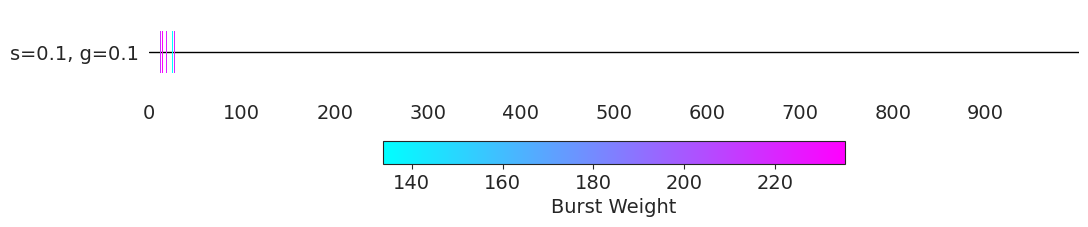

ended  [0.1, 0.1]
started  [1.0, 0.1]


/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: divide by zero encountered in log
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))


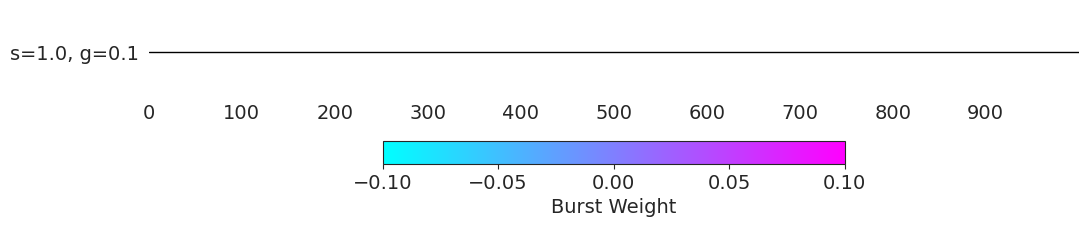

ended  [1.0, 0.1]
started  [0.1, 1.0]


/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: divide by zero encountered in log
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))


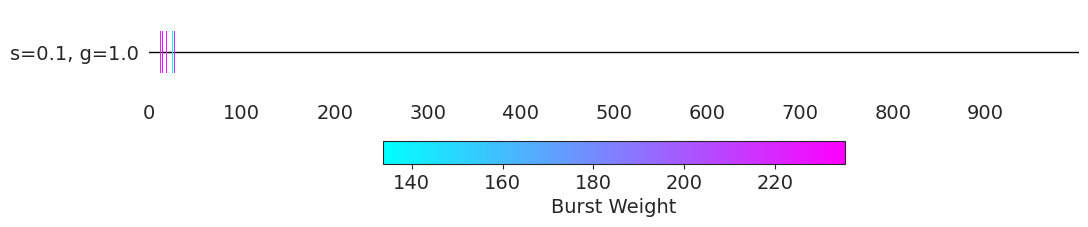

ended  [0.1, 1.0]
started  [1.0, 1.0]


/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: divide by zero encountered in log
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))


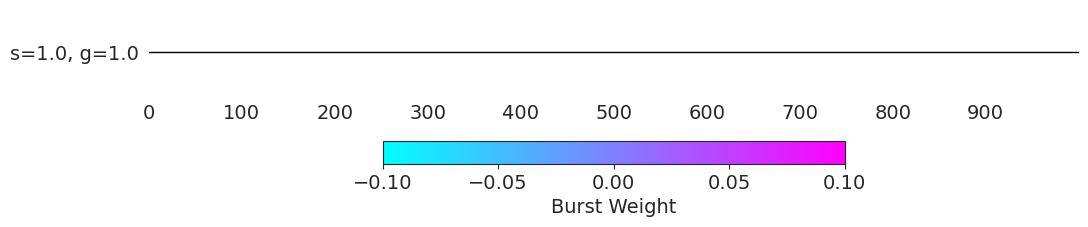

ended  [1.0, 1.0]
started  [0.1, 2.0]


/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: divide by zero encountered in log
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))


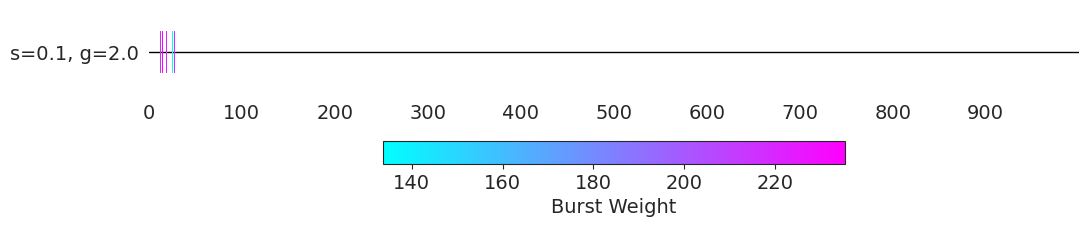

ended  [0.1, 2.0]
started  [1.0, 2.0]


/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))
/tmp/ipykernel_500473/1283834156.py:26: RuntimeWarning: divide by zero encountered in log
  return -np.log(float(c.binomial(d, r)) * (p**r) * (1 - p)**(d - r))


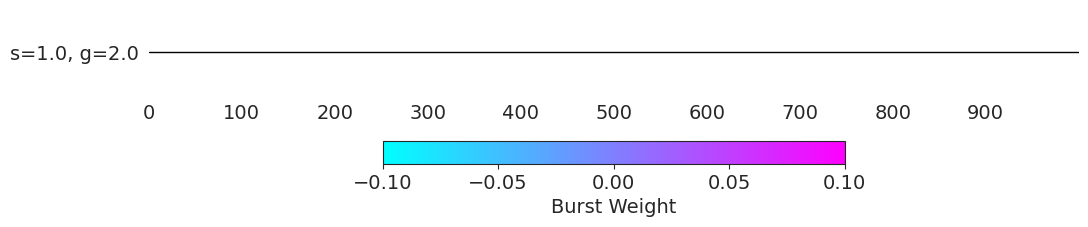

ended  [1.0, 2.0]


In [176]:
#find bursts

#define variables
#number of timepoints
n_gpu = len(r_gpu) 
#number of states
k = 2

#col 0: s -- resolution of state jumps; higher s --> bigger jumps between states
#col 1: gamma -- difficulty of moving up a state; larger gamma --> harder to move up states
variables = [[0.1, 0.1],
             [1.0, 0.1],
             [0.1, 1.0],
             [1.0, 1.0],
             [0.1, 2.0],
             [1.0, 2.0],
]

for v in variables:
    print("started ", v)
    #find the optimal state sequence (using the Viterbi algorithm)
    [q, _, _, p] = burst_detection(r_gpu,d_gpu,n_gpu,v[0],v[1],smooth_win=5)

    #create label
    label = 's='+str(v[0])+', g='+str(v[1])

    #enumerate the bursts
    bursts = enumerate_bursts(q, label)

    #find weight of each burst
    bursts = burst_weights(bursts, r, d, p)
    
    #plot the optimal state sequence
    plot_burst_timeline(bursts, timepoints, label)
    
    print("ended ", v)